# **<center> Madrid Houses: Modeling </center>**
![Immune](https://i.imgur.com/0TSSaqL.png)  

In [30]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
import os
import pandas as pd
import json
import pickle
import optuna
import xgboost as xgb
from xgboost  import XGBRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from paths import RAW_DIR, PROCESSED_DIR, SUBMISSIONS_DIR, MODELS_DIR, METRICS_DIR
from functions import compute_metrics, predict_best_model
from transformers import ExtractDataNeighborhood, FillNA, RemoveOutliers
import warnings
from datetime import datetime

warnings.filterwarnings('ignore')

RANDOM_STATE = 42

raw_train_df = pd.read_csv(os.path.join(RAW_DIR, 'train.csv'))
raw_predict_df = pd.read_csv(os.path.join(RAW_DIR, 'predict.csv'))

In [34]:
# Split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(raw_train_df, raw_train_df['buy_price_by_area'], test_size=0.2, random_state=RANDOM_STATE, shuffle=True)

In [35]:
# Numerical features
numerical_columns = ['sq_mt_built', 'n_rooms', 'n_bathrooms']

# Categorical features
categorical_columns = ['floor', 'house_type_id', 'energy_certificate']

# Features for filling NA with False
fill_na_false_columns = [
    'has_lift', 
    'is_new_development', 
    'has_central_heating', 
    'has_ac', 
    'has_parking', 
    'is_exterior', 
    'has_garden', 
    'has_pool', 
    'has_terrace', 
    'has_balcony', 
    'has_storage_room', 
    'has_green_zones', 
    'has_fitted_wardrobes']

# Features for filling NA with True
fill_na_true_columns = [
    'is_parking_included_in_price',
    'is_renewal_needed',
]

numeric_etl = ColumnTransformer(
    transformers=[
        ('remove_outliers', RemoveOutliers(['rent_price']), ['rent_price']),
        ('loc_info', ExtractDataNeighborhood(data='numerical'), ['neighborhood_id']),
        ('_', 'passthrough', numerical_columns),
    ],
    remainder='drop')


numeric_transformer = Pipeline(steps=[
    ('etl', numeric_etl),
    ('scaler', StandardScaler())
])

categorical_etl = ColumnTransformer(
    transformers=[
        ('loc_info', ExtractDataNeighborhood(data='categorical'), ['neighborhood_id']),
        ('cat_bool', FillNA(fill_na_false_columns, type_fill='False'), fill_na_false_columns),
        ('cat_bool_2', FillNA(fill_na_true_columns, type_fill='True'), fill_na_true_columns),
        ('_', 'passthrough', categorical_columns)
    ],
    remainder='drop')

categorical_transformer = Pipeline(steps=[
    ('etl', categorical_etl),
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False))
])

etl_pipeline = FeatureUnion(
    transformer_list=[
        ('numeric', numeric_transformer),
        ('categorical', categorical_transformer)
    ])

In [36]:
# Fit the ETL pipeline
etl_pipeline.fit(X_train, y_train)

# Transform the train data
train_transformed = pd.DataFrame(etl_pipeline.transform(X_train), columns=etl_pipeline.get_feature_names_out())
train_transformed['buy_price_by_area'] = y_train.values

# Transform the test data
test_transformed = pd.DataFrame(etl_pipeline.transform(X_test), columns=etl_pipeline.get_feature_names_out())
test_transformed['buy_price_by_area'] = y_test.values

# Save train dataset in parquet format
train_file_name = f'train_{datetime.now().strftime("%Y-%m-%d_%H-%M-%S")}.parquet'
train_file_path = os.path.join(PROCESSED_DIR, train_file_name)
train_transformed.to_parquet(train_file_path)

# Save test dataset in parquet format
test_file_name = f'test_{datetime.now().strftime("%Y-%m-%d_%H-%M-%S")}.parquet'
test_file_path = os.path.join(PROCESSED_DIR, test_file_name)
test_transformed.to_parquet(test_file_path)

In [37]:
# Import the last train and test datasets
train_df = pd.read_parquet(train_file_path)
test_df = pd.read_parquet(test_file_path)

X_train = train_df.drop('buy_price_by_area', axis=1)
y_train = train_df['buy_price_by_area']

X_test = test_df.drop('buy_price_by_area', axis=1)
y_test = test_df['buy_price_by_area']

dtrain = xgb.DMatrix(X_train, label=y_train)

In [54]:
def objective(trial):
    '''
    Objective function for the hyperparameter optimization.

    Parameters
    ----------
    trial : optuna.trial.Trial
        A trial object to access the hyperparameters to optimize.

    Returns
    -------
    float
        The mean of the cross validation scores.
    '''
    
    # Define the hyperparameters to optimize
    optimize_params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.15, log=True),
        'importance_type': trial.suggest_categorical('importance_type', ['gain', 'weight', 'cover', 'total_gain', 'total_cover']),
        'max_depth': trial.suggest_int('max_depth', 5, 8),
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 1),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 1),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
    }

    fixed_params = {
        'booster': 'gbtree',
        'n_jobs': -1,
        'objective': 'reg:squarederror',
        'nfolds': 5,
        'eval_metric': 'rmse',
        'seed': RANDOM_STATE
    }
   
    # xgbost cross validation
    # results = xgb.cv({**optimize_params, **fixed_params}, 
    #                  dtrain)
    
    model = XGBRegressor(**{**optimize_params, **fixed_params})

    # use sklearn cross validation for negative mape
    results = cross_val_score(model, X_train, y_train, scoring='neg_mean_absolute_percentage_error')

    return results.mean()

In [55]:
# Create the sampler to make reproducible results
sampler = optuna.samplers.TPESampler(seed=RANDOM_STATE)

# Create the study
study = optuna.create_study(direction='maximize', study_name='xgboost_optimize', sampler=sampler)

# Optimize the study
study.optimize(lambda trail: objective(trail), n_trials=100, show_progress_bar=True, n_jobs=1)

# Get the best hyperparameters
best_params = study.best_params

# Create the XGBoost model with the best hyperparameters
model = XGBRegressor(**best_params)

# Fit the model
model.fit(X_train, y_train)

[I 2023-10-03 17:11:05,435] A new study created in memory with name: xgboost_optimize


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2023-10-03 17:11:09,687] Trial 0 finished with value: -0.08112865438379424 and parameters: {'learning_rate': 0.02757359293934948, 'importance_type': 'gain', 'max_depth': 5, 'n_estimators': 447, 'reg_alpha': 0.6011150117432088, 'reg_lambda': 0.7080725777960455, 'subsample': 0.5102922471479012, 'colsample_bytree': 0.9849549260809971, 'gamma': 0.8324426408004217, 'min_child_weight': 3}. Best is trial 0 with value: -0.08112865438379424.
[I 2023-10-03 17:11:12,234] Trial 1 finished with value: -0.11061844709684014 and parameters: {'learning_rate': 0.016362239850894633, 'importance_type': 'cover', 'max_depth': 7, 'n_estimators': 155, 'reg_alpha': 0.29214464853521815, 'reg_lambda': 0.3663618432936917, 'subsample': 0.728034992108518, 'colsample_bytree': 0.8925879806965068, 'gamma': 0.19967378215835974, 'min_child_weight': 6}. Best is trial 0 with value: -0.08112865438379424.
[I 2023-10-03 17:11:17,597] Trial 2 finished with value: -0.06047573233146104 and parameters: {'learning_rate': 0.049

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.985077136597312, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0.15116883369460515,
             grow_policy=None, importance_type='cover',
             interaction_constraints=None, learning_rate=0.06080734694051027,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=419, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [56]:
# Save the model in pickle file
model_file_name = f'model_{model.__class__.__name__}_{datetime.now().strftime("%Y-%m-%d_%H-%M-%S")}.pkl'
model_file_path = os.path.join(MODELS_DIR, model_file_name)

pickle.dump(model, open(model_file_path, 'wb'))

model

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.985077136597312, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0.15116883369460515,
             grow_policy=None, importance_type='cover',
             interaction_constraints=None, learning_rate=0.06080734694051027,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=419, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [57]:
optuna.visualization.plot_optimization_history(study)

In [58]:
optuna.visualization.plot_param_importances(study)

In [59]:
optuna.visualization.plot_slice(study)

In [60]:
optuna.visualization.plot_parallel_coordinate(study)

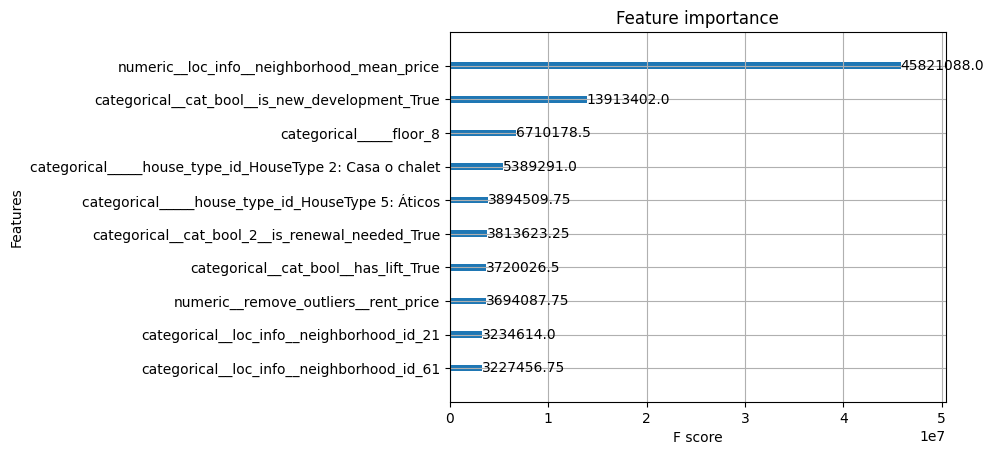

In [63]:
xgb.plot_importance(model, max_num_features=10, importance_type='gain');

In [64]:
# Make predictions on the test set
y_train_pred = model.predict(X_train)
y_pred = model.predict(X_test)

# Eval Model 
metrics = compute_metrics(model, y_test, y_pred, y_train, y_train_pred)


Train/Test split results:
XGBRegressor r2 is 0.910
XGBRegressor mean_squared_error is 328472.632
XGBRegressor mean_absolute_error is 239.680
XGBRegressor mape test is 0.051
XGBRegressor mape train is 0.019


In [65]:
# Save metrics and model parameters in json format
metrics_names = ('r2', 'mse', 'mae', 'mape_test', 'mape_train')

metrics_dict = {metric_name: metric_value for metric_name, metric_value in zip(metrics_names, metrics)}

to_save = {
    'model_fit_params': best_params,
    'model_params': model.get_params(),
    'metrics': metrics_dict
    }

metrics_file_name = f'metrics_{model.__class__.__name__}_{datetime.now().strftime("%Y-%m-%d_%H-%M-%S")}_{round(metrics_dict["mape_test"], 4)}.json'
metrics_file_path = os.path.join(METRICS_DIR, metrics_file_name)

with open(metrics_file_path, 'w') as f:
    json.dump(to_save, f)

## KAGGLE SUBMISSION

In [66]:
# Make predictions on the predict set
submission = predict_best_model(model, etl_pipeline, raw_predict_df)

# Submission path
submission_file_name = f'submission_{model.__class__.__name__}_{datetime.now().strftime("%Y-%m-%d_%H-%M-%S")}_{round(metrics_dict["mape_test"], 4)}.csv'
submission_file_path = os.path.join(SUBMISSIONS_DIR, submission_file_name)

# Save submission
submission.to_csv(submission_file_path, index=False)